### Import the Dependencies

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import timedelta

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# better default plot settings
sns.set(style="whitegrid")

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
# To ignore common warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Load the dataset into data frame
df = pd.read_csv('online_retail.csv')

In [5]:
# View basic structure
print("Shape of dataset:", df.shape)
print("\nColumns and Data Types:")
print(df.info())

Shape of dataset: (541909, 8)

Columns and Data Types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None


In [6]:
# Preview the data
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2022 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2022 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2022 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2022 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2022 8:26,3.39,17850.0,United Kingdom


### Data Quality Checks

In [8]:
# Check missing values
print("\nMissing Values:\n", df.isnull().sum())


Missing Values:
 InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [9]:
# Check for duplicate rows
duplicates = df.duplicated().sum()
print(f"Duplicate Rows: {duplicates}")

Duplicate Rows: 5268


In [10]:
# Summary statistics
df.describe(include='all')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,541909,541909,540455,541909.000000,541909,541909.000000,406829.000000,541909
unique,25900,4070,4223,NaN,23260,NaN,NaN,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,10/31/2023 14:41,NaN,NaN,United Kingdom
freq,1114,2313,2369,NaN,1114,NaN,NaN,495478
mean,NaN,NaN,NaN,9.552250,NaN,4.611114,15287.690570,NaN
std,NaN,NaN,NaN,218.081158,NaN,96.759853,1713.600303,NaN
min,NaN,NaN,NaN,-80995.000000,NaN,-11062.060000,12346.000000,NaN
25%,NaN,NaN,NaN,1.000000,NaN,1.250000,13953.000000,NaN
50%,NaN,NaN,NaN,3.000000,NaN,2.080000,15152.000000,NaN
75%,NaN,NaN,NaN,10.000000,NaN,4.130000,16791.000000,NaN


### Cleaning the Data

In [12]:
# Drop duplicates
df = df.drop_duplicates()

In [13]:
# Drop rows with missing CustomerID
df = df.dropna(subset=['CustomerID'])

In [14]:
# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [15]:
# Remove cancelled invoices (InvoiceNo starting with 'C')
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

In [16]:
# Remove rows with negative or zero Quantity or UnitPrice
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

In [17]:
# Reset index after all filtering
df.reset_index(drop=True, inplace=True)

In [18]:
# Check final shape and preview
print("Cleaned Data Shape:", df.shape)
df.head()

Cleaned Data Shape: (392692, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2022-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2022-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom


##  Exploratory Data Analysis (EDA):

### Transaction Volume by Country

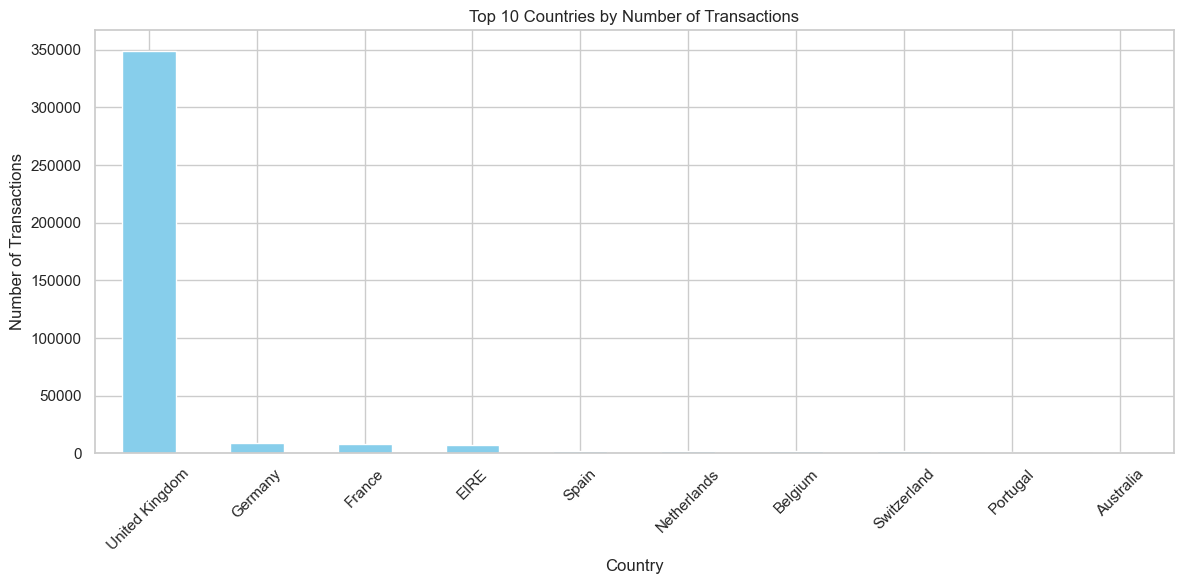

In [21]:
country_orders = df['Country'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
country_orders.head(10).plot(kind='bar', color='skyblue')
plt.title('Top 10 Countries by Number of Transactions')
plt.ylabel('Number of Transactions')
plt.xlabel('Country')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 🌍 Country-wise Transaction Report

- The **United Kingdom** has the highest number of transactions by a very large margin, showing it is the main market.
- Other countries like **Germany, France, and Ireland (EIRE)** have much fewer transactions in comparison.
- The remaining top 10 countries — including **Spain, Netherlands, and Australia** — show only small levels of activity.
- This suggests the business is mostly focused on UK customers, and there may be opportunities to grow internationally.

### Top-Selling Products

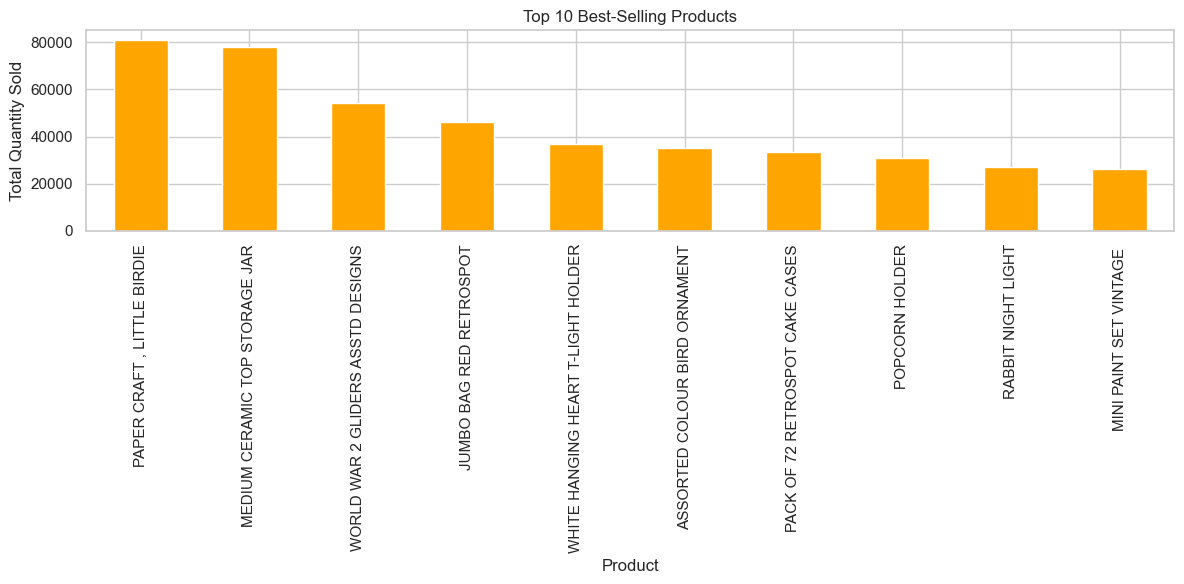

In [24]:
top_products = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
top_products.plot(kind='bar', color='orange')
plt.title('Top 10 Best-Selling Products')
plt.xlabel('Product')
plt.ylabel('Total Quantity Sold')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### 🛒 Best-Selling Products Report

- **"PAPER CRAFT, LITTLE BIRDIE"** is the top-selling product, followed closely by **"MEDIUM CERAMIC TOP STORAGE JAR"**.
- Products related to **home decor** and **crafts** dominate the top 10 list.
- Most of the top items have sold **over 30,000 units**, showing strong customer interest.
- These popular products can be prioritized for promotions, bundles, or recommendations.

### Purchase Trends Over Time

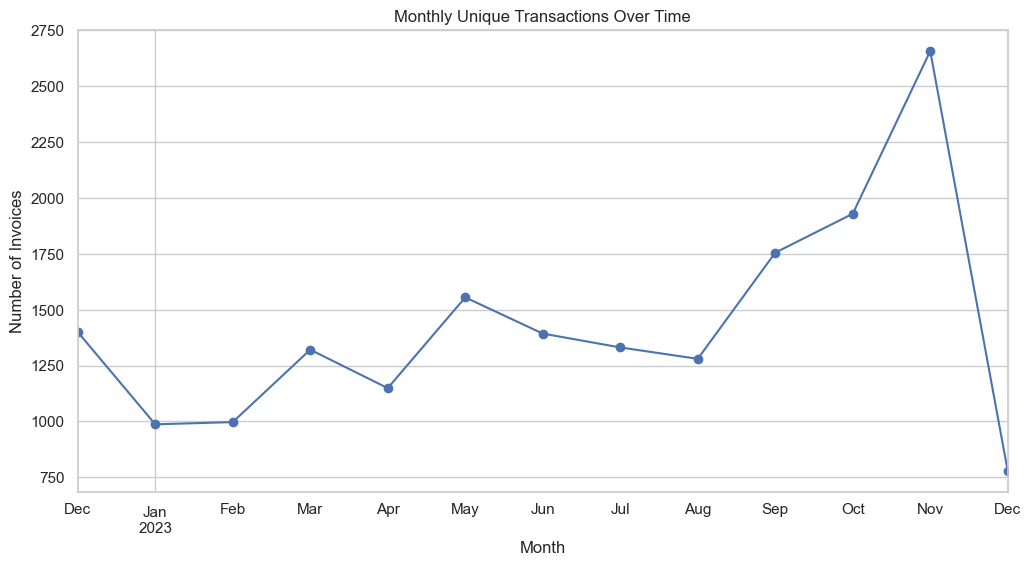

In [27]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')

monthly_sales = df.groupby('InvoiceMonth')['InvoiceNo'].nunique()

plt.figure(figsize=(12, 6))
monthly_sales.plot(marker='o')
plt.title('Monthly Unique Transactions Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Invoices')
plt.grid(True)
plt.show()

### 📅 Monthly Transactions Report

- The number of transactions was **lowest in January and February**, then started rising gradually.
- A sharp **increase occurred in September to November**, with **November being the peak month**.
- This trend may be influenced by **holiday shopping or seasonal promotions**.
- December shows a sudden drop, which could be due to **incomplete data or fewer business days**.

### Monetary Distribution per Transaction and Customer

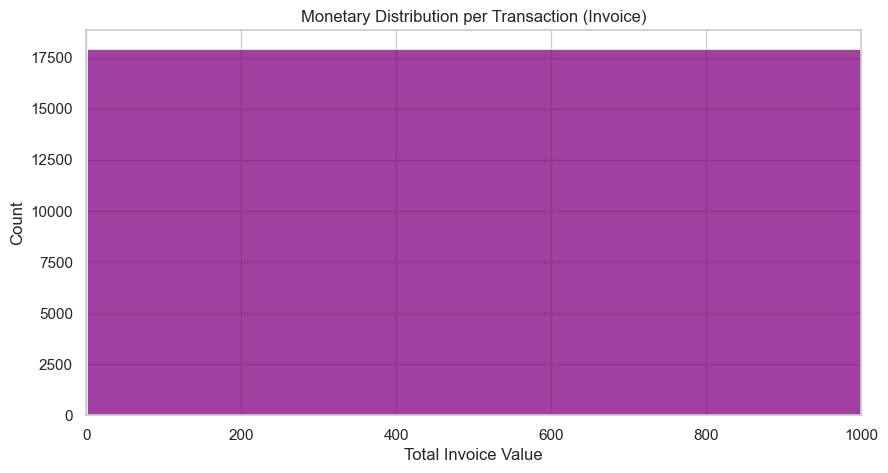

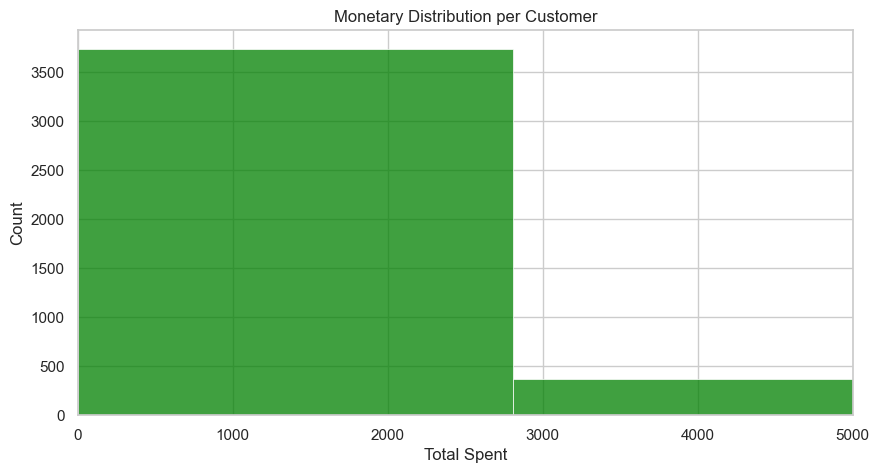

In [30]:
# Total price per line
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Per transaction
invoice_value = df.groupby('InvoiceNo')['TotalPrice'].sum()

plt.figure(figsize=(10, 5))
sns.histplot(invoice_value, bins=100, color='purple')
plt.xlim(0, 1000)
plt.title('Monetary Distribution per Transaction (Invoice)')
plt.xlabel('Total Invoice Value')
plt.show()

# Per customer
customer_value = df.groupby('CustomerID')['TotalPrice'].sum()

plt.figure(figsize=(10, 5))
sns.histplot(customer_value, bins=100, color='green')
plt.xlim(0, 5000)
plt.title('Monetary Distribution per Customer')
plt.xlabel('Total Spent')
plt.show()

### 💰 Monetary Distribution Report

- Most invoices have a **total value below 1,000**, suggesting small or medium-sized purchases are common.
- The vast majority of customers have spent **less than 3,000** overall.
- A few customers made higher purchases, but they are **rare (outliers)**.
- This indicates a **broad customer base with mostly low-to-mid value orders**, and a few high-value customers.

### RFM Distributions

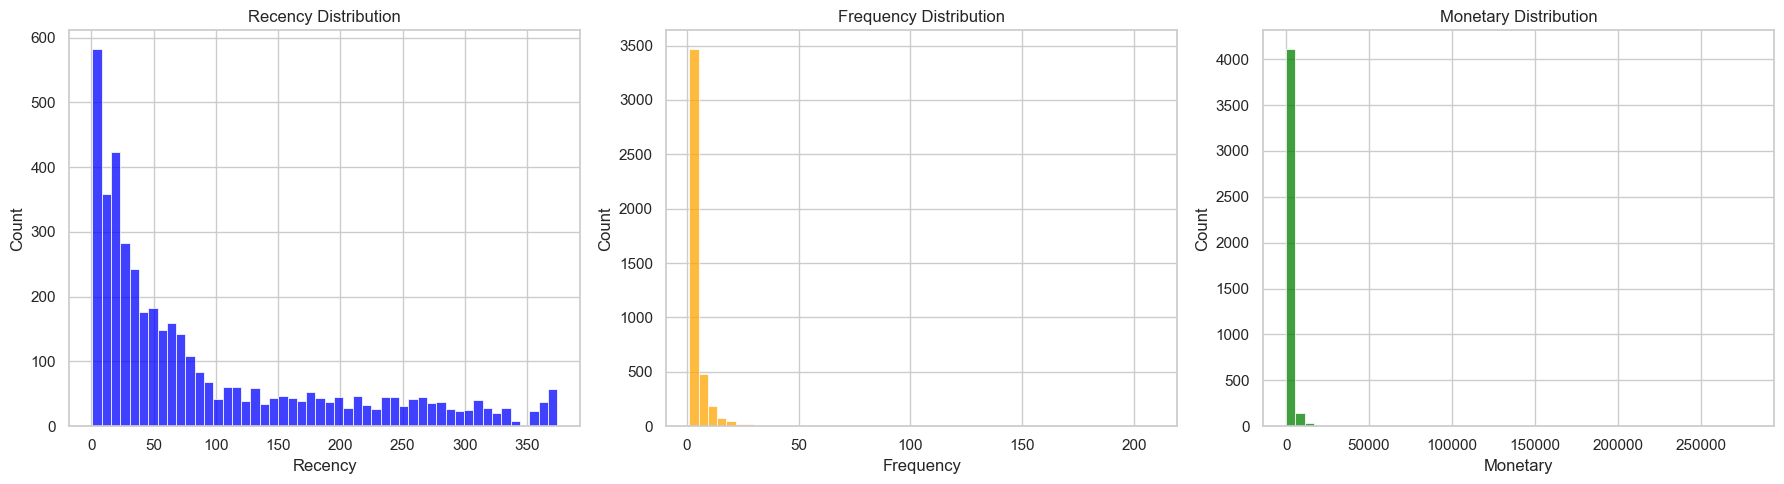

In [33]:
# Reference date = day after last invoice
latest_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Compute RFM
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (latest_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'TotalPrice': 'Monetary'})

# Plot RFM distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.histplot(rfm['Recency'], bins=50, ax=axes[0], color='blue')
axes[0].set_title('Recency Distribution')

sns.histplot(rfm['Frequency'], bins=50, ax=axes[1], color='orange')
axes[1].set_title('Frequency Distribution')

sns.histplot(rfm['Monetary'], bins=50, ax=axes[2], color='green')
axes[2].set_title('Monetary Distribution')
plt.tight_layout()
plt.show()

### 📊 RFM Distribution Report

- **Recency**: Most customers made purchases recently (within 50 days), suggesting active engagement.
- **Frequency**: The majority of customers purchased only once or twice, showing low repeat buying.
- **Monetary**: Most customers spent smaller amounts, while a few spent significantly more — indicating the presence of high-value customers.
- Overall, the business has many **low-frequency, low-spend buyers** with **some valuable loyal customers** worth targeting.

### Elbow Curve for KMeans Cluster Selection

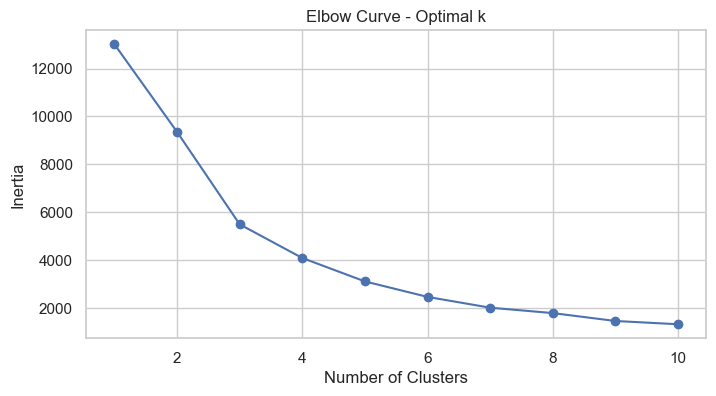

In [36]:
# Scale RFM
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

# Elbow method
inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K, inertia, marker='o')
plt.title('Elbow Curve - Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

### Customer Cluster Profiles

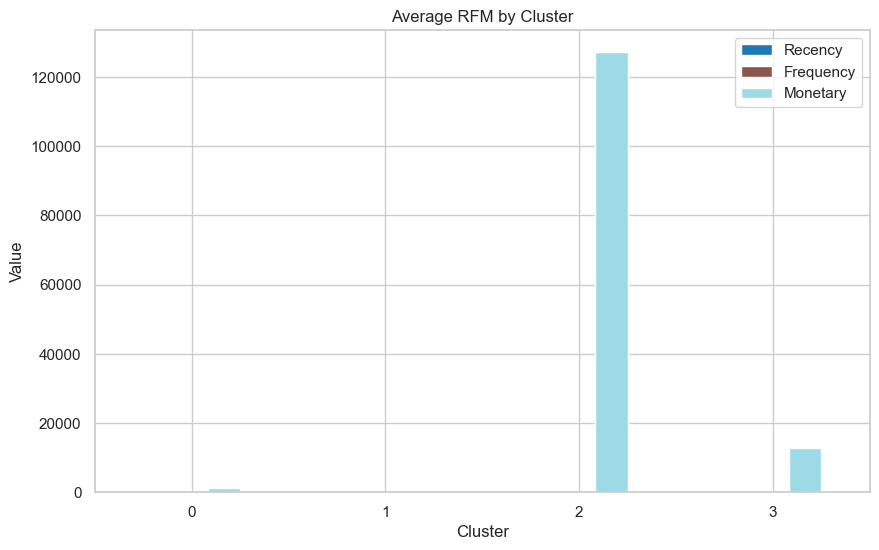

In [38]:
# Apply k-means
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Average RFM per cluster
cluster_summary = rfm.groupby('Cluster').mean()

# Visualize
cluster_summary.plot(kind='bar', figsize=(10, 6), colormap='tab20')
plt.title('Average RFM by Cluster')
plt.ylabel('Value')
plt.xticks(rotation=0)
plt.show()

### Product Recommendation Heatmap (Cross-Sell)

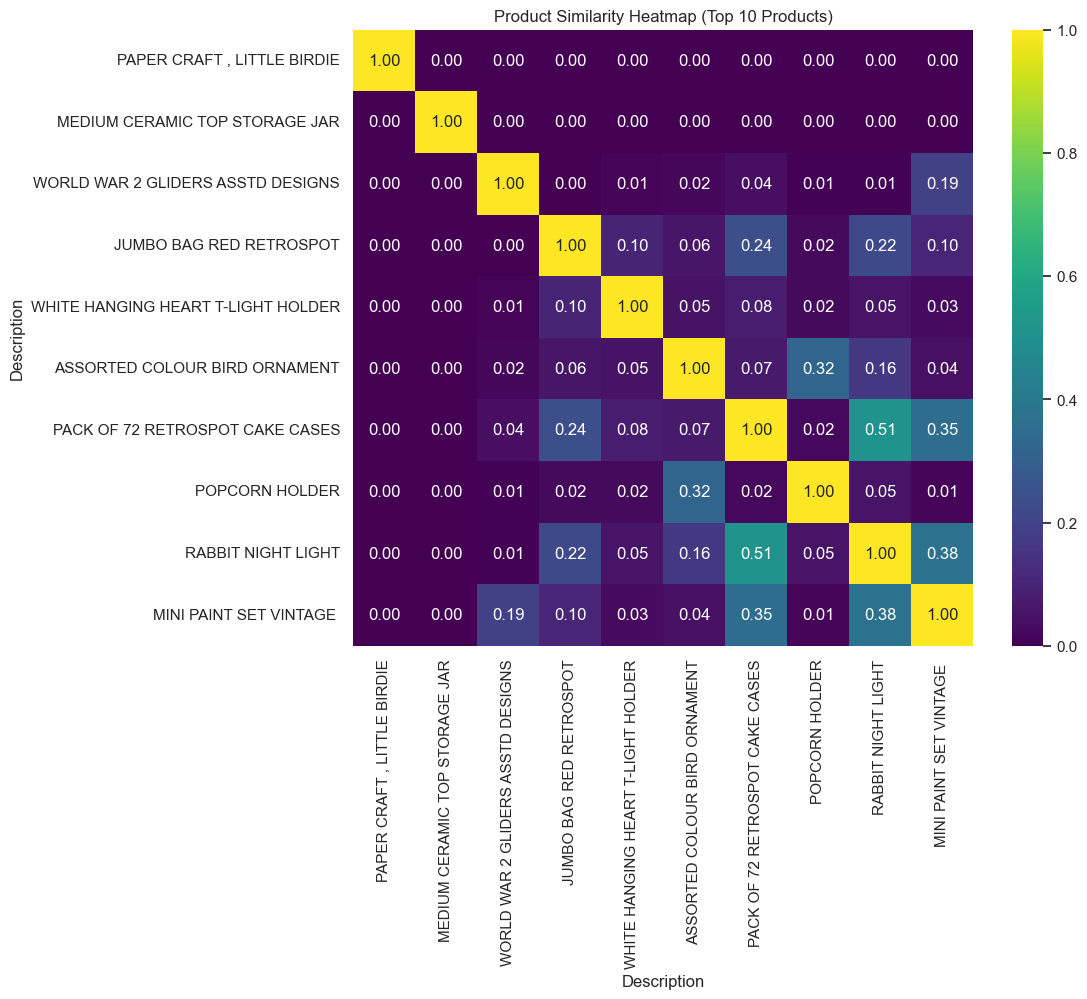

In [40]:
# Create pivot table of products by customer
basket = df.pivot_table(index='CustomerID', columns='Description', values='Quantity', aggfunc='sum').fillna(0)

# Normalize and compute cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

# Compute similarity matrix
product_similarity = cosine_similarity(basket.T)
product_similarity_df = pd.DataFrame(product_similarity, index=basket.columns, columns=basket.columns)

# Heatmap of top N similar products
top_n = 10
top_products = basket.sum().sort_values(ascending=False).head(top_n).index

plt.figure(figsize=(10, 8))
sns.heatmap(product_similarity_df.loc[top_products, top_products], cmap='viridis', annot=True, fmt=".2f")
plt.title('Product Similarity Heatmap (Top 10 Products)')
plt.show()

### Feature Engineering (RFM)

In [42]:
# Calculate TotalPrice for each row
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Define reference date (1 day after last transaction)
ref_date = df['InvoiceDate'].max() + timedelta(days=1)

# Create RFM table
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (ref_date - x.max()).days,    # Recency
    'InvoiceNo': 'nunique',                                # Frequency
    'TotalPrice': 'sum'                                    # Monetary
}).reset_index()

# Rename columns
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

### Standardize RFM values

In [44]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

### Choose Algorithm + Elbow & Silhouette

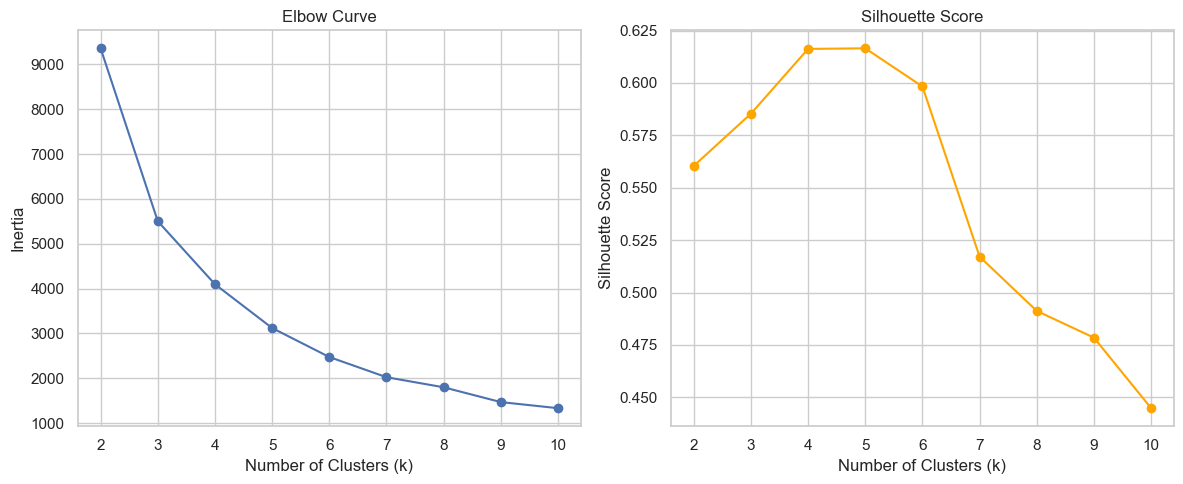

In [46]:
inertia = []
silhouette = []
K = range(2, 11)

for k in K:
    model = KMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(rfm_scaled)
    inertia.append(model.inertia_)
    silhouette.append(silhouette_score(rfm_scaled, labels))

# Plot Elbow and Silhouette
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(K, inertia, marker='o')
plt.title('Elbow Curve')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')

plt.subplot(1, 2, 2)
plt.plot(K, silhouette, marker='o', color='orange')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

In [47]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

### Label the clusters based on RFM averages

In [49]:
def label_segment(row):
    # High R, High F, High M → High-Value
    if row['Recency'] <= rfm['Recency'].quantile(0.33) and \
       row['Frequency'] > rfm['Frequency'].quantile(0.66) and \
       row['Monetary'] > rfm['Monetary'].quantile(0.66):
        return 'High-Value'

    # Medium F, Medium M → Regular
    elif rfm['Frequency'].quantile(0.33) < row['Frequency'] <= rfm['Frequency'].quantile(0.66) and \
         rfm['Monetary'].quantile(0.33) < row['Monetary'] <= rfm['Monetary'].quantile(0.66):
        return 'Regular'

    # Low F, Low M, older R → Occasional
    elif row['Frequency'] <= rfm['Frequency'].quantile(0.33) and \
         row['Monetary'] <= rfm['Monetary'].quantile(0.33) and \
         row['Recency'] > rfm['Recency'].quantile(0.66):
        return 'Occasional'

    # High R, Low F, Low M → At-Risk
    else:
        return 'At-Risk'

In [50]:
rfm['Segment'] = rfm.apply(label_segment, axis=1)

### Visualize clusters using PCA (2D)

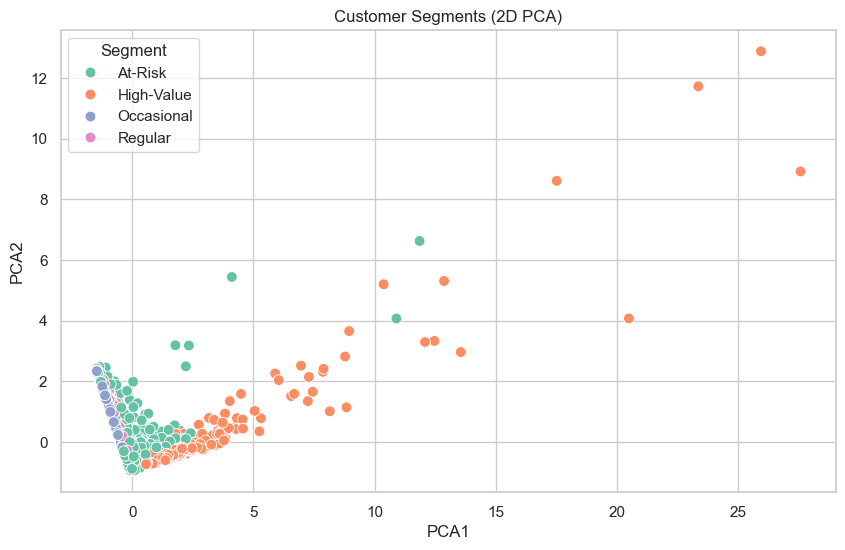

In [52]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(rfm_scaled)
rfm['PCA1'], rfm['PCA2'] = pca_components[:, 0], pca_components[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm, x='PCA1', y='PCA2', hue='Segment', palette='Set2', s=60)
plt.title('Customer Segments (2D PCA)')
plt.grid(True)
plt.show()

 ### Visualize Segment Distribution

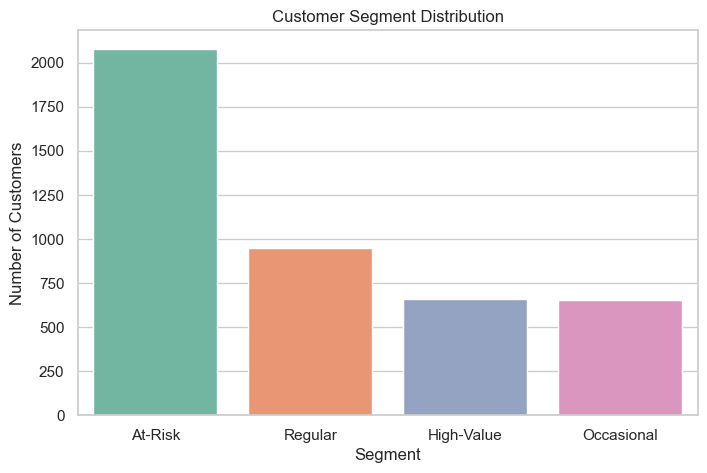

In [54]:
plt.figure(figsize=(8, 5))
sns.countplot(data=rfm, x='Segment', palette='Set2', order=rfm['Segment'].value_counts().index)
plt.title('Customer Segment Distribution')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.grid(True, axis='y')
plt.show()

In [55]:
segment_summary = rfm.groupby('Segment')[['Recency', 'Frequency', 'Monetary']].mean().round(2)
print(segment_summary)

            Recency  Frequency  Monetary
Segment                                 
At-Risk       78.22       3.03   1425.94
High-Value     9.55      13.69   7765.79
Occasional   243.46       1.00    199.69
Regular       77.82       2.70    711.08


# Recommendation System:

### Create Customer–Product Matrix

In [58]:
# Create pivot table: rows = customers, columns = products, values = purchase count
item_matrix = df.pivot_table(index='CustomerID',
                              columns='StockCode',
                              values='Quantity',
                              aggfunc='sum').fillna(0)

### Compute Cosine Similarity Between Products

In [60]:
# Transpose so products are rows
product_similarity = cosine_similarity(item_matrix.T)

# Convert to DataFrame with StockCodes as index/columns
product_sim_df = pd.DataFrame(product_similarity,
                              index=item_matrix.columns,
                              columns=item_matrix.columns)

### Build Product Lookup Dictionary

In [62]:
# Create StockCode → Product Description lookup
product_names = df[['StockCode', 'Description']].drop_duplicates().set_index('StockCode')['Description'].to_dict()

In [63]:
product_names

{'85123A': 'CREAM HANGING HEART T-LIGHT HOLDER',
 '71053': 'WHITE MOROCCAN METAL LANTERN',
 '84406B': 'CREAM CUPID HEARTS COAT HANGER',
 '84029G': 'KNITTED UNION FLAG HOT WATER BOTTLE',
 '84029E': 'RED WOOLLY HOTTIE WHITE HEART.',
 '22752': 'SET 7 BABUSHKA NESTING BOXES',
 '21730': 'GLASS STAR FROSTED T-LIGHT HOLDER',
 '22633': 'HAND WARMER UNION JACK',
 '22632': 'HAND WARMER RED RETROSPOT',
 '84879': 'ASSORTED COLOUR BIRD ORNAMENT',
 '22745': "POPPY'S PLAYHOUSE BEDROOM ",
 '22748': "POPPY'S PLAYHOUSE KITCHEN",
 '22749': 'FELTCRAFT PRINCESS CHARLOTTE DOLL',
 '22310': 'IVORY KNITTED MUG COSY ',
 '84969': 'BOX OF 6 ASSORTED COLOUR TEASPOONS',
 '22623': 'BOX OF VINTAGE JIGSAW BLOCKS ',
 '22622': 'BOX OF VINTAGE ALPHABET BLOCKS',
 '21754': 'HOME BUILDING BLOCK WORD',
 '21755': 'LOVE BUILDING BLOCK WORD',
 '21777': 'RECIPE BOX WITH METAL HEART',
 '48187': 'DOORMAT NEW ENGLAND',
 '22960': 'JAM MAKING SET WITH JARS',
 '22913': 'RED COAT RACK PARIS FASHION',
 '22912': 'YELLOW COAT RACK PARIS F

### Recommend by Product Name

In [65]:
def recommend_by_product_name(product_name, top_n=5):
    # 1. Search for the StockCode using partial name match
    def get_code_by_name(name):
        for code, desc in product_names.items():
            if name.lower() in desc.lower():
                return code
        return None

    # 2. Recommend based on similar products
    def recommend_products(stock_code, top_n):
        if stock_code not in product_sim_df:
            return [f"❌ StockCode {stock_code} not found in similarity matrix."]
        
        sim_scores = product_sim_df[stock_code].sort_values(ascending=False).drop(stock_code)
        top_similar = sim_scores.head(top_n).index
        return [f"{code} - {product_names.get(code, 'Unknown Product')}" for code in top_similar]

    # 3. Main logic: get StockCode, recommend
    code = get_code_by_name(product_name)
    if code:
        print(f"📌 Recommendations for: {product_names[code]} ({code})")
        return recommend_products(code, top_n)
    else:
        return [f"❌ Product name '{product_name}' not found."]

In [66]:
recommendations = recommend_by_product_name("RED HANGING HEART T-LIGHT HOLDER")
for rec in recommendations:
    print(rec)

📌 Recommendations for: RED HANGING HEART T-LIGHT HOLDER (21733)
22117 - METAL SIGN HER DINNER IS SERVED 
22479 - DAISY GARDEN MARKER
21897 - POTTING SHED CANDLE CITRONELLA
21898 - POTTING SHED ROSE CANDLE
82551 - LAUNDRY 15C METAL SIGN


In [107]:
import joblib

# Save similarity matrix and product name dictionary
joblib.dump(product_sim_df, "product_similarity.pkl")
joblib.dump(product_names, "product_names.pkl")
print("✔️ Recommendation model saved.")

✔️ Recommendation model saved.


In [109]:
# Save scaler and model
joblib.dump(scaler, "scaler.pkl")
joblib.dump(kmeans, "kmeans_model.pkl")
print("✅ Saved: scaler.pkl & kmeans_model.pkl")

✅ Saved: scaler.pkl & kmeans_model.pkl
